In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
import tensorflow.keras.layers as L
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow.keras import layers
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
batch_size = 6
lr = 1e-3
epochs = 300
width = 256
height = 256

In [3]:
dataset_path = os.path.join("/kaggle/input/uavid-v1")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [4]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "uavid_train","seq1", "Images", "*")))
    train_y = sorted(glob(os.path.join(path, "uavid_train","seq1", "Labels", "*")))

    valid_x = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Images", "*")))
    valid_y = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Labels", "*")))

    return (train_x, train_y), (valid_x, valid_y)

In [5]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

train_x, additional_valid_x, train_y, additional_valid_y = train_test_split(
    train_x, train_y, test_size=100, random_state=42
)

valid_x = np.concatenate([valid_x, additional_valid_x], axis=0)
valid_y = np.concatenate([valid_y, additional_valid_y], axis=0)


print(f"New Train: {len(train_x)} - {len(train_y)}")
print(f"New Valid: {len(valid_x)} - {len(valid_y)}")

New Train: 500 - 500
New Valid: 170 - 170


In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [7]:
color_map = {
    (0, 0, 0): 0,         # Background clutter
    (128, 0, 0): 1,       # Building
    (128, 64, 128): 2,    # Road
    (0, 128, 0): 3,       # Tree
    (128, 128, 0): 4,     # Low vegetation
    (64, 0, 128): 5,      # Moving car
    (192, 0, 192): 6,     # Static car
    (64, 64, 0): 7        # Human
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    class_indices = np.zeros((height, width), dtype=np.uint8)
    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx
    
    # Convert to one-hot encoding
    one_hot_mask = tf.one_hot(class_indices, depth=8)  # 8 classes as per your color_map
    return one_hot_mask.numpy()

In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 8])  # 8 classes
    return x, y

In [9]:
def tf_dataset(x, y, batch=6):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
# test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [ ]:
# # Create a custom color map based on the color_map dictionary
# color_map_values = list(color_map.keys())
# color_map_rgb = np.array(color_map_values) / 255.0  # Normalize to 0-1 range for matplotlib

# def plot_samples_with_labels(dataset, title):
#     plt.figure(figsize=(12, 12))
#     for i, (images, masks) in enumerate(dataset.take(1)):  # Take a single batch
#         for j in range(4):  # Loop over first four images
#             # Plot the image
#             plt.subplot(4, 4, j*2 + 1)
#             plt.imshow(images[j].numpy())
#             plt.axis("off")
#             plt.title(f"{['Train', 'Validation', 'Test'][title]} Image {j+1}")

#             # Convert one-hot mask back to class indices
#             class_indices = np.argmax(masks[j].numpy(), axis=-1)

#             # Convert class indices to RGB colors
#             mask_rgb = np.zeros((height, width, 3), dtype=np.float32)
#             for idx, color in enumerate(color_map_rgb):
#                 mask_rgb[class_indices == idx] = color

#             # Plot the label mask
#             plt.subplot(4, 4, j*2 + 2)
#             plt.imshow(mask_rgb)
#             plt.axis("off")
#             plt.title(f"{['Train', 'Validation', 'Test'][title]} Mask {j+1}")
    
#     plt.tight_layout()
#     plt.show()


# # Plot the images and corresponding label masks for each dataset
# plot_samples_with_labels(train_dataset, title=0)   # Train images and masks
# plot_samples_with_labels(valid_dataset, title=1)   # Validation images and masks
# plot_samples_with_labels(test_dataset, title=2)    # Test images and masks

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers as L

# class AdaptiveAvgPool2D(tf.keras.layers.Layer):
#     """TensorFlow equivalent of PyTorch's AdaptiveAvgPool2d(1)."""
#     def __init__(self, output_size=(1, 1), **kwargs):
#         super(AdaptiveAvgPool2D, self).__init__(**kwargs)
#         self.output_size = output_size  # Default to (1,1) like PyTorch

#     def call(self, inputs):
#         input_shape = tf.shape(inputs)
#         h, w = input_shape[1], input_shape[2]  # Get spatial dimensions

#         # Compute dynamic pool size
#         pool_size = (h // self.output_size[0], w // self.output_size[1])

#         return tf.keras.layers.AveragePooling2D(pool_size=pool_size, strides=pool_size)(inputs)

# def eca_layer(x, k_size=3):
#     """Efficient Channel Attention (ECA) with Adaptive Avg Pooling."""
#     ch_avg = AdaptiveAvgPool2D(output_size=(1, 1))(x)  # Adaptive pooling

#     # Reshape for 1D Conv
#     ch_avg = tf.squeeze(ch_avg, axis=[1, 2])  # Shape: (batch, channels)
#     ch_avg = tf.expand_dims(ch_avg, axis=-1)  # Shape: (batch, channels, 1)

#     # 1D Convolution for cross-channel interaction
#     ch_avg = L.Conv1D(1, kernel_size=k_size, padding="same", use_bias=False)(ch_avg)
#     ch_avg = L.Activation("sigmoid")(ch_avg)

#     # Reshape back and apply attention
#     ch_avg = tf.reshape(ch_avg, [-1, 1, 1, x.shape[-1]])  # Shape: (batch, 1, 1, channels)
#     x_ch = L.Multiply()([x, ch_avg])  # Channel-wise recalibration

#     return x_ch

# def eca_scse_module(x, k_size=3):
#     """ECA-enhanced scSE (Efficient Channel Squeeze & Spatial Excitation + Spatial Squeeze & Efficient Channel Excitation)"""

#     # Efficient Channel Attention (ECA replaces SE)
#     x_ch = eca_layer(x, k_size)

#     # Spatial Attention
#     spatial = L.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
#     x_sp = L.Multiply()([x, spatial])

#     # Combining both attentions
#     x_out = L.Add()([x_ch, x_sp])
#     return x_out

**In PyTorch, AdaptiveAvgPool2d(1) is used to ensure an output of (1,1,C) regardless of input size.**

**In TensorFlow, GlobalAveragePooling2D(keepdims=True) already returns (1,1,C), making it functionally the same.**

In [11]:
import tensorflow as tf
from tensorflow.keras import layers as L

class ECALayer(L.Layer):
    """ Efficient Channel Attention (ECA) Layer """
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.k_size = k_size
        self.conv = L.Conv1D(1, kernel_size=k_size, padding="same", use_bias=False)
        self.sigmoid = L.Activation("sigmoid")

    def call(self, x):
        ch_avg = L.GlobalAveragePooling2D(keepdims=True)(x)  
        ch_avg = tf.squeeze(ch_avg, axis=[1, 2])  
        ch_avg = tf.expand_dims(ch_avg, axis=-1)  

        ch_avg = self.conv(ch_avg)  
        ch_avg = self.sigmoid(ch_avg)

        ch_avg = tf.reshape(ch_avg, [-1, 1, 1, x.shape[-1]]) 

        eca = x * ch_avg
        return eca 

In [12]:
def SpaCE(x, k_size=3):
    """ECA-enhanced scSE (Efficient Channel Squeeze & Spatial Excitation + Spatial Squeeze & Efficient Channel Excitation)"""
    
    # Efficient Channel Attention (ECA replaces SE)
    eca = ECALayer(k_size)(x)

    # Spatial Attention
    spatial = L.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    sSE = L.Multiply()([x, spatial])

    # Combining both attentions
    x_out = L.Add()([eca, sSE])
    return x_out

In [13]:
def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)
    x = SpaCE(x)  # SCSE
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape, num_classes=12):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer")

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = SpaCE(e5)                 # SCSE
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = SpaCE(d4)                # SCSE
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = SpaCE(d3)           # SCSE
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = SpaCE(d2)              # SCSE
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = SpaCE(d1)  # SCSE
    d1 = conv_block(d1, 64*5)

    """ Output """
    y1 = L.Conv2D(num_classes, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("softmax")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model

In [19]:
input_shape = (height, width, 3)
num_classes = 8

# Instantiate the model
model = unet3plus(input_shape, num_classes)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 256, 256, 64)   │            256 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_44             │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_44[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 256, 256, 64)   │            256 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 256, 256, 1)    │             65 │ activation_45[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ eca_layer_9 (ECALayer)    │ (None, 256, 256, 64)   │              3 │ activation_45[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_9 (Multiply)     │ (None, 256, 256, 64)   │              0 │ activation_45[0][0],   │
│                           │                        │                │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 256, 256, 64)   │              0 │ eca_layer_9[0][0],     │
│                           │                        │                │ multiply_9[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 128, 128, 64)   │              0 │ add_9[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 128, 128, 128)  │            512 │ conv2d_47[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47             │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 27,008,300 (103.03 MB)

 Trainable params: 26,995,244 (102.98 MB)

 Non-trainable params: 13,056 (51.00 KB)

In [21]:
alpha = 0.25
gamma = 2.0

# Compile the model with focal loss
opt = tf.keras.optimizers.Adam(lr)
model.compile(
    loss=tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=gamma,
        from_logits=False  # Since we have softmax activation in the final layer
    ),
    optimizer=opt,
    metrics=['categorical_accuracy']
)

In [22]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [23]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4623 - loss: 0.2558
Epoch 1: val_loss improved from inf to 0.41805, saving model to files/modified_uavid_dataset/UnetModel.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - categorical_accuracy: 0.4630 - loss: 0.2550 - val_categorical_accuracy: 0.1755 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 2/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5979 - loss: 0.1424
Epoch 2: val_loss did not improve from 0.41805
84/84 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - categorical_accuracy: 0.5980 - loss: 0.1424 - val_categorical_accuracy: 0.1705 - val_loss: 0.5974 - learning_rate: 0.0010
Epoch 3/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6357 - loss: 0.1255
Epoch 3: val_loss did not improve from 0.41805
84/84 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - categorical_accuracy: 0.6358 - loss: 0.1254 - val_categorical_accuracy: 0.1703 - val_loss: 0.5463 - learning_rate: 0.0010
Epoch 4/300
84/84

In [24]:
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [25]:
tf.keras.config.enable_unsafe_deserialization()
custom_objects = {
    "SpaCE": SpaCE,
    "ECALayer": ECALayer
}
model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'eca_layer_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'eca_layer_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'eca_layer_11', however the layer does no

Index(['epoch', 'categorical_accuracy', 'learning_rate', 'loss',
       'val_categorical_accuracy', 'val_loss'],
      dtype='object')


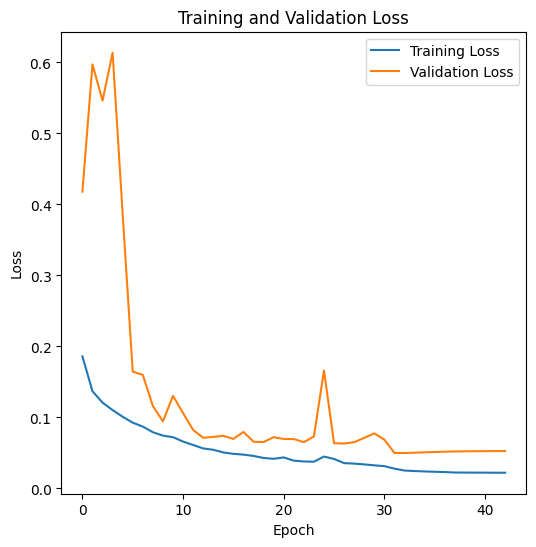

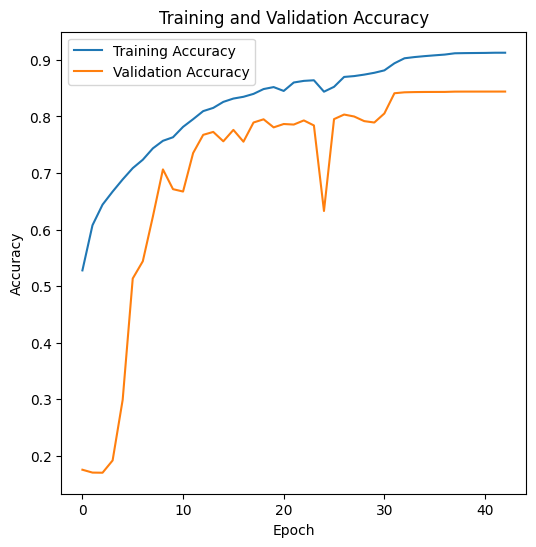

In [26]:
import pandas as pd
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)
# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['categorical_accuracy'], label='Training Accuracy')
plt.plot(log_data['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


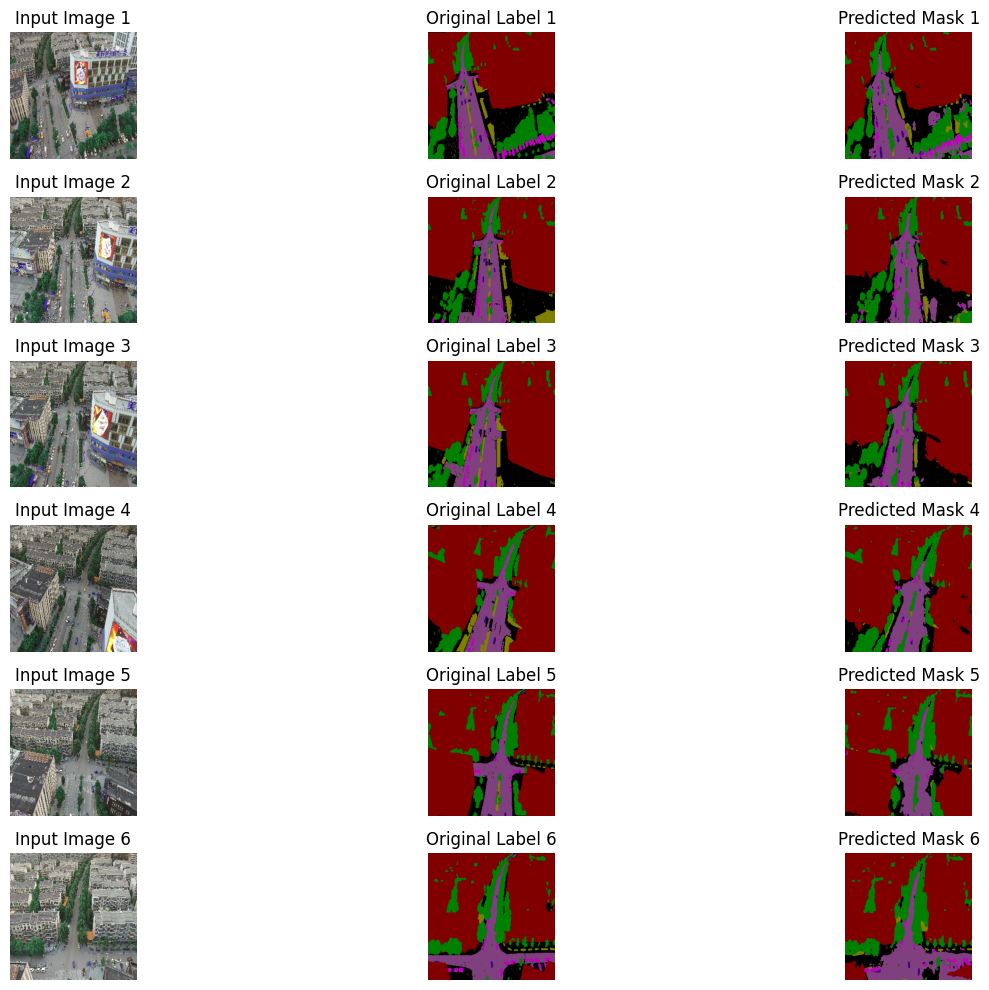

In [29]:
class_to_rgb = {v: k for k, v in color_map.items()}

class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask


plt.figure(figsize=(15, 10))  

batch = next(iter(valid_dataset)) 
batch_x, batch_y = batch

num_images = batch_x.shape[0]

for i in range(num_images):

    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()


    prediction = model.predict(np.expand_dims(image, axis=0))[0]  
    predicted_class_indices = np.argmax(prediction, axis=-1) 

    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    original_label_path = valid_y[i] 
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [31]:
import time

# colors = [
#     (0, 0, 0),           # Background
#     (192, 128, 128),     # Person
#     (0, 128, 0),         # Bike
#     (128, 128, 128),     # Car
#     (128, 0, 0),         # Drone
#     (0, 0, 128),         # Boat
#     (192, 0, 128),       # Animal
#     (192, 0, 0),         # Obstacle
#     (192, 128, 0),       # Construction
#     (0, 64, 0),          # Vegetation
#     (128, 128, 0),       # Road
#     (0, 128, 128),       # Sky
# ]

time_taken = []
for x in tqdm(valid_x):
    
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0] 
    total_time = time.time() - start_time
    time_taken.append(total_time)

    p_class_indices = np.argmax(p, axis=-1)  
    
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb 
    
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

  0%|          | 0/170 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 1/170 [00:00<00:57,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 2/170 [00:00<00:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 3/170 [00:01<00:55,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 4/170 [00:01<00:55,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 5/170 [00:01<00:54,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▎         | 6/170 [00:01<00:53,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 7/170 [00:02<00:53,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▍         | 8/170 [00:02<00:53,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 9/170 [00:02<00:52,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 10/170 [00:03<00:52,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▋         | 11/170 [00:03<00:51,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 12/170 [00:03<00:50,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 13/170 [00:04<00:50,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 14/170 [00:04<00:49,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 15/170 [00:04<00:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 16/170 [00:05<00:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 17/170 [00:05<00:49,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 18/170 [00:05<00:49,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 19/170 [00:06<00:49,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 20/170 [00:06<00:48,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 21/170 [00:06<00:48,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 22/170 [00:07<00:48,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▎        | 23/170 [00:07<00:48,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 24/170 [00:07<00:48,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▍        | 25/170 [00:08<00:48,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▌        | 26/170 [00:08<00:47,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▌        | 27/170 [00:08<00:47,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▋        | 28/170 [00:09<00:47,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 29/170 [00:09<00:47,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 30/170 [00:09<00:46,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 31/170 [00:10<00:46,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 32/170 [00:10<00:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 33/170 [00:10<00:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 34/170 [00:11<00:46,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 35/170 [00:11<00:47,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 36/170 [00:11<00:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 37/170 [00:12<00:46,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 38/170 [00:12<00:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 39/170 [00:12<00:45,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▎       | 40/170 [00:13<00:44,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 41/170 [00:13<00:44,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▍       | 42/170 [00:14<00:43,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 43/170 [00:14<00:43,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 44/170 [00:14<00:43,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▋       | 45/170 [00:15<00:43,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 46/170 [00:15<00:42,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 47/170 [00:15<00:43,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 48/170 [00:16<00:42,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 49/170 [00:16<00:41,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 50/170 [00:16<00:42,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 51/170 [00:17<00:40,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 52/170 [00:17<00:39,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 53/170 [00:17<00:38,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 54/170 [00:18<00:37,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 55/170 [00:18<00:37,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 56/170 [00:18<00:36,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 57/170 [00:19<00:36,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 58/170 [00:19<00:35,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▍      | 59/170 [00:19<00:35,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▌      | 60/170 [00:20<00:35,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 61/170 [00:20<00:36,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▋      | 62/170 [00:20<00:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 63/170 [00:21<00:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 64/170 [00:21<00:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 65/170 [00:21<00:36,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 66/170 [00:22<00:36,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 67/170 [00:22<00:35,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 68/170 [00:22<00:34,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 69/170 [00:23<00:34,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 70/170 [00:23<00:34,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 71/170 [00:23<00:32,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 72/170 [00:24<00:32,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 73/170 [00:24<00:32,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▎     | 74/170 [00:24<00:32,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 75/170 [00:25<00:31,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 76/170 [00:25<00:30,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 77/170 [00:25<00:30,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 78/170 [00:26<00:29,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▋     | 79/170 [00:26<00:30,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 80/170 [00:26<00:30,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 81/170 [00:27<00:30,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 82/170 [00:27<00:29,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▉     | 83/170 [00:27<00:28,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 84/170 [00:28<00:28,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 85/170 [00:28<00:28,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████     | 86/170 [00:28<00:28,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 87/170 [00:29<00:28,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 88/170 [00:29<00:27,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 89/170 [00:29<00:26,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 90/170 [00:30<00:26,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▎    | 91/170 [00:30<00:26,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 92/170 [00:30<00:26,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 93/170 [00:31<00:26,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 94/170 [00:31<00:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 95/170 [00:31<00:25,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▋    | 96/170 [00:32<00:25,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 97/170 [00:32<00:24,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 98/170 [00:32<00:24,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 99/170 [00:33<00:23,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 100/170 [00:33<00:22,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 101/170 [00:33<00:22,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 102/170 [00:34<00:21,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████    | 103/170 [00:34<00:21,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████    | 104/170 [00:34<00:21,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 105/170 [00:35<00:21,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 106/170 [00:35<00:20,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 107/170 [00:35<00:20,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▎   | 108/170 [00:36<00:20,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 109/170 [00:36<00:20,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 110/170 [00:36<00:19,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▌   | 111/170 [00:37<00:19,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 112/170 [00:37<00:18,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▋   | 113/170 [00:37<00:18,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 114/170 [00:38<00:18,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 115/170 [00:38<00:18,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 116/170 [00:38<00:17,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 117/170 [00:39<00:16,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▉   | 118/170 [00:39<00:16,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 119/170 [00:39<00:16,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 120/170 [00:40<00:16,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 121/170 [00:40<00:15,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 122/170 [00:40<00:15,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 123/170 [00:41<00:15,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 124/170 [00:41<00:15,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▎  | 125/170 [00:41<00:14,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 126/170 [00:42<00:14,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 127/170 [00:42<00:14,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 128/170 [00:42<00:13,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 129/170 [00:43<00:13,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▋  | 130/170 [00:43<00:13,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 131/170 [00:43<00:13,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 132/170 [00:44<00:12,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 133/170 [00:44<00:12,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 134/170 [00:44<00:12,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 135/170 [00:45<00:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 136/170 [00:45<00:11,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 137/170 [00:45<00:11,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 138/170 [00:46<00:10,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 139/170 [00:46<00:10,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 140/170 [00:46<00:10,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 141/170 [00:47<00:09,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▎ | 142/170 [00:47<00:09,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▍ | 143/170 [00:47<00:09,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 144/170 [00:48<00:08,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 145/170 [00:48<00:08,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▌ | 146/170 [00:48<00:08,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▋ | 147/170 [00:49<00:07,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 148/170 [00:49<00:07,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 149/170 [00:49<00:07,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 150/170 [00:50<00:06,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 151/170 [00:50<00:06,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 152/170 [00:50<00:06,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|█████████ | 153/170 [00:51<00:05,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 154/170 [00:51<00:05,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 155/170 [00:51<00:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 156/170 [00:52<00:04,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 157/170 [00:52<00:04,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 158/170 [00:52<00:04,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▎| 159/170 [00:53<00:03,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 160/170 [00:53<00:03,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|█████████▍| 161/170 [00:53<00:02,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 162/170 [00:54<00:02,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 163/170 [00:54<00:02,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▋| 164/170 [00:54<00:02,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 165/170 [00:55<00:01,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 166/170 [00:55<00:01,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 167/170 [00:55<00:01,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 168/170 [00:56<00:00,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 169/170 [00:56<00:00,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████| 170/170 [00:56<00:00,  2.99it/s]


In [32]:
!zip -r uavidECAscse.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'uavidECAscse.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/Prediction/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq1_flipped141.png (deflated 13%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq16_file29-8.png (deflated 11%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq16_file22-7.png (deflated 16%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq16_file24-3.png (deflated 14%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq16_file24-4.png (deflated 11%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq16_file22-9.png (deflated 15%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq1_file12-5.png (deflated 14%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq16_file21-8.png (deflated 17%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq1_flipped132.png (deflated 16%)
  a

/kaggle/working/uavidECAscse.zip